# Multivariable Linear Regression
With simple linear regression, we have one independent and one dependent variable. These relationships are easy to plot and visualize on a graph. However, with real-world situations, there are often multiple factors that affect an outcome. This can make it difficult to visualize the relationships between the variables. A possible solution is to use some form of a decision tree, which, after splitting and pruning, will provide a much more intuitive explanation. Nevertheless, we explore the algorithm of multivariable linear regression using gradient descent in this Jupyter Notebook, attempting to find a linear relationship between the independent and dependent variables.

It is important to note that there is a difference between multivaria**BLE** and multivaria**TE** regression. Multivariable regression uses multiple predictor variables but only **ONE** outcome variable while multivariate regression has multiple outcome variables.

## Libraries
For this implementation, we will use pandas to read in data from CSV files, NumPy arrays for fast calculations, scikit-learn to split our data into training and validation sets, and matplotlib to visualize the process. Although the pandas DataFrames can be used directly throughout the gradient descent (by converting extracted rows to NumPy arrays), converting them to NumPy arrays before applying the regression will greatly decrease computation time (especially for large data sets) because indexing for DataFrames is quite slow.

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Functions
This section includes the functions necessary for data processing, error calculation, and gradient descent iteration.

### Data Processing
Linear regression does not require normalization of the values, but doing this decreases the chances of overflowing the capacity of a float in Python due to high error from large values. Min-Max Normalization will be sufficient in this example, independently performing it on each variable to linearly scale values between the minimums and maximums of their respective columns.

$$v_{new}=\frac{v_{old}-min(v_{old})}{max(v_{old})-min(v_{old})}$$

Since the minimums and maximums may not be defined and included in the data, we need to be able to reverse this in order to put the predicted values into a readable, comprehensible form. Therefore, these extremes are returned by the `normalize_minmax` function to be saved and used by the `denorm` function after iteration.

In [18]:
def normalize_minmax(data):
    mins = data.min(axis=0)
    maxs = data.max(axis=0)
    data = (data - mins) / (maxs - mins)
    return data, mins, maxs

def denorm(pred, mins, maxs, col):
    return pred * (maxs[col] - mins[col]) + mins[col]

### Gradient Descent
The `predict` function not only serves to reduce redundancy in the other functions found in this section but also to provide a method to use the model to predict new data points, using the equation below. $\hat{y}$ is the predicted outcome variable, $x_i$ are the predictor variables, and $\beta_i$ are the values we will adjust to reduce the error.

$$\hat{y}=\beta_0+\beta_1x_1+\beta_2x_2+\ldots+\beta_nx_n$$

In [19]:
def predict(point, betas):
    return betas[0] + np.dot(betas[1:], point.T)

For linear regression, we will use mean squared error as the cost function, represented by the following equation. Choosing a good cost function to perform regression with is important because we want to use one that has only one local minimum, which is the global minimum.

$$J=\frac{1}{n}\sum_{i=1}^{n} (y_i-\hat{y_i})^2$$

In [20]:
def mse(data, betas):
    rows, cols = data.shape
    loss = 0
    for i in range(rows):
        loss += pow(data[i][cols - 1] - predict(data[i][:cols - 1], betas), 2)
    loss *= 1 / rows
    return loss

The `iterate` function contains the actual gradient descent iteration.

#### Conceptual Visualization
Imagine you are on a hill and are trying to get to the bottom. However, there is a problem—you are blindfolded and don't know where the bottom is. Therefore, you feel the ground close to you. The left slopes up, in front slopes up, same with behind. On the other hand, the right slopes down, so what direction should you step in? The right. You keep repeating this process until you are essentially at your destination, the bottom of the hill. At a single moment in time, a single position, you know which direction the hill slants. We can use this information to decide where to advance. Although this visualization is not completely accurate, this is essentially how gradient descent works.

#### Algorithm
With gradient descent, the aim is to minimize the cost, or loss. In other words, we want to improve each of the $\beta$-values to a state where the cost is at its global minimum. To calculate these new values, we use the equation below.

$$\beta_{k_{new}}=\beta_{k_{old}}-\alpha\frac{\partial J}{\partial \beta_k}$$

$J$ represents the cost function, defined above, and $\alpha$ is the learning rate of the model. The partial derivative of $J$ with respect to $\beta_i$ is the slope of the cost with respect to $\beta_i$, which the model uses to step in the correct direction.

$$\frac{\partial J}{\partial \beta_k}=-\frac{2}{n}\sum_{i=1}^{n} (y_i-\hat{y_i}) \text{    for } k=0$$
$$\frac{\partial J}{\partial \beta_k}=-\frac{2}{n}\sum_{i=1}^{n} (y_i-\hat{y_i})x_{k_i} \text{    for } k>0$$

In [21]:
def iterate(data_train, data_test, betas, epochs, learning_rate):
    metrics = {
        'loss_train': [mse(data_train, betas)],
        'loss_test': [mse(data_test, betas)],
    }
    rows, cols = data_train.shape
    for k in range(epochs):
        dbetas = np.zeros(len(betas))
        for i in range(rows):
            temp = data_train[i][cols - 1] - predict(data_train[i][:cols - 1], betas)
            dbetas[0] += temp
            dbetas[1:] += temp * data_train[i][:cols - 1]
        dbetas *= -2 / rows
        betas -= dbetas * learning_rate
        metrics['loss_train'].append(mse(data_train, betas))
        metrics['loss_test'].append(mse(data_test, betas))
    return metrics

## Examples
Now that the linear regression with gradient descent iteration is defined, we can test it on data. We will first use data created for this example and split it into 90% training and 10% validation, shuffling it to provide more randomness. Splitting the data into these two sets will confirm that the model can predict values accurately for data it has never seen before—it is a measure against overfitting.

In [55]:
data = pd.read_csv('linreg_data.csv')
print(data)
data = data.to_numpy()
train, test = train_test_split(data, test_size=0.1, shuffle=True)

   x  y
0  0  6
1  1  4
2  2  3
3  3  3
4  4  1
5  5  0


Let's iterate for 100 epochs at a learning rate of 0.06 and see what happens.

In [56]:
eps = 100
lr = 0.06
betas = np.zeros(train.shape[1])

metrics = iterate(train, test, betas, eps, lr)

The errors for both the training and test data sets start pretty high, but as the iteration progresses, they decrease and eventually converge. A learning rate that is too high can cause the algorithm to diverge or be inefficient in reaching convergence due to overshooting the minimum. A learning rate that is too low will require many epochs to converge, again making it inefficient. Therefore, the learning rate should be chosen accordingly.

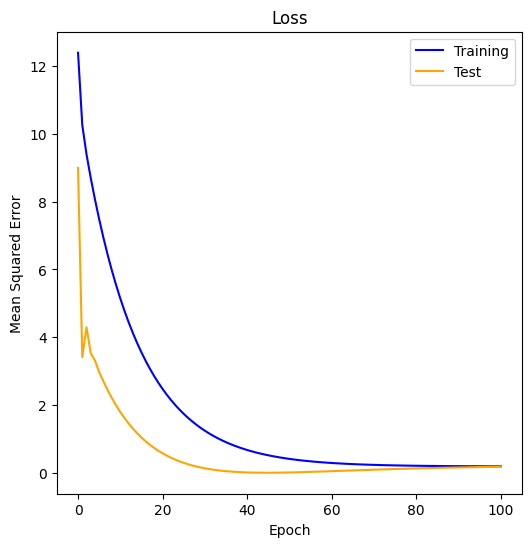

In [57]:
plt.figure(figsize=(6, 6))
plt.plot(range(eps + 1), metrics['loss_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['loss_test'], c='orange', label='Test')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()

In [58]:
print('Loss (Train):\t{}'.format(metrics['loss_train'][eps]))
print('Loss (Test):\t{}'.format(metrics['loss_test'][eps]))

Loss (Train):	0.18842861254312948
Loss (Test):	0.17708188716342915


We can also see how the model performs on real data. This red wine quality data set contains information about certain wines, such as acidity, pH, and quality. Let's use every variable except for the quality as predictor variables to predict the quality. To prevent overflow in Python, the data is normalized between 0 and 1.

In [42]:
wine_red = pd.read_csv('winequality-red.csv', sep=';')
wine_red, denorm_min, denorm_max = normalize_minmax(wine_red)
print(wine_red.head(10))
wine_red = wine_red.to_numpy()

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.247788          0.397260         0.00        0.068493   0.106845   
1       0.283186          0.520548         0.00        0.116438   0.143573   
2       0.283186          0.438356         0.04        0.095890   0.133556   
3       0.584071          0.109589         0.56        0.068493   0.105175   
4       0.247788          0.397260         0.00        0.068493   0.106845   
5       0.247788          0.369863         0.00        0.061644   0.105175   
6       0.292035          0.328767         0.06        0.047945   0.095159   
7       0.238938          0.363014         0.00        0.020548   0.088481   
8       0.283186          0.315068         0.02        0.075342   0.101836   
9       0.256637          0.260274         0.36        0.356164   0.098497   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.140845              0.098940  0.567548  0.6062

In [43]:
betas = np.zeros(wine_red.shape[1])
eps = 1000
lr = 0.2

train, test = train_test_split(wine_red, test_size=0.1, shuffle=True)
metrics = iterate(train, test, betas, eps, lr)

Again, the cost decreases and eventually flattens out i.e. converges.

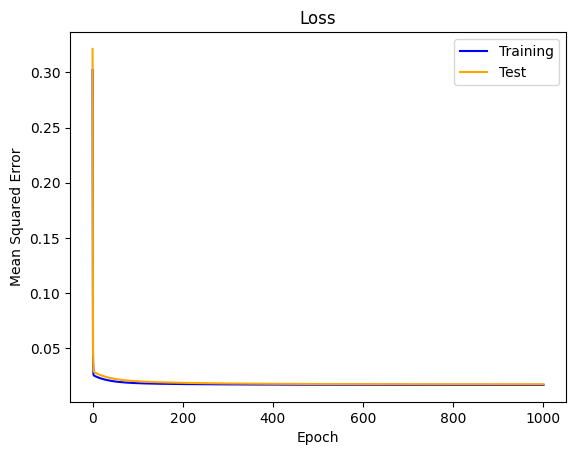

In [44]:
plt.plot(range(eps + 1), metrics['loss_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['loss_test'], c='orange', label='Test')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()

In [50]:
print('Loss (Train):\t{}'.format(metrics['loss_train'][eps]))
print('Loss (Test):\t{}'.format(metrics['loss_test'][eps]))

Loss (Train):	0.01668275685027738
Loss (Test):	0.01726592853319004


After the model is trained, it can be used to predict the quality of red wine, given the predictor variables.

In [51]:
pred = 10
print('Normalized Actual Quality:\t\t{}'.format(test[pred][test.shape[1] - 1]))
print('Normalized Predicted Quality:\t{}'.format(predict(test[pred][:test.shape[1] - 1], betas)))
print('Denormalized Actual Quality:\t{}'.format(denorm(test[pred][test.shape[1] - 1], denorm_min, denorm_max, 'quality')))
print('Denormalized Predicted Quality:\t{}'.format(denorm(predict(test[pred][:test.shape[1] - 1], betas), denorm_min, denorm_max, 'quality')))

Normalized Actual Quality:		0.6
Normalized Predicted Quality:	0.5742604430006906
Denormalized Actual Quality:	6.0
Denormalized Predicted Quality:	5.871302215003453


## Final Thoughts
Linear regression is one of the simplest machine learning algorithms. It is basically the "Hello World" of machine learning. As with many other techniques, we can use it on real data and visualize the progression of gradient descent. Although situations in reality often require models able to represent non-linear relationships, linear regression is powerful in education and a great starting point.